Using device: cuda
Results will be saved to: finalmodels/WKNN/Grid_100m/k_11/weights_distance/

--- Single Run Evaluation ---
Training WKNN model with k=11, weights=distance
Model trained in 0.00 seconds
Prediction completed in 8.28 seconds

--- Single Run Results ---
Grid Size: 100m
K value: 11
Weights type: distance
Mean 2D Error: 3.38 meters
90th Percentile Error: 6.54 meters
Grid Accuracy (Reciprocal): 0.9704
Grid Accuracy (Gaussian): 0.9704
Grid Accuracy (Softmax): 0.9704
Training Time: 0.00 seconds
Prediction Time: 8.28 seconds

--- Starting Multiple Run Analysis (50 runs) ---
Run 1/50...
Prediction completed in 8.66 seconds
Prediction completed in 8.78 seconds
Prediction completed in 8.86 seconds
Prediction completed in 9.10 seconds
Prediction completed in 9.43 seconds
Prediction completed in 9.52 seconds
Prediction completed in 10.58 seconds
Prediction completed in 9.61 seconds
Prediction completed in 10.44 seconds
Prediction completed in 8.54 seconds
Run 11/50...
Prediction co

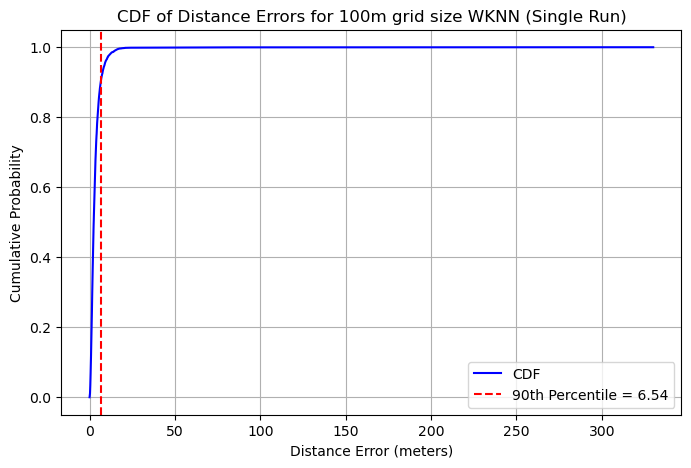

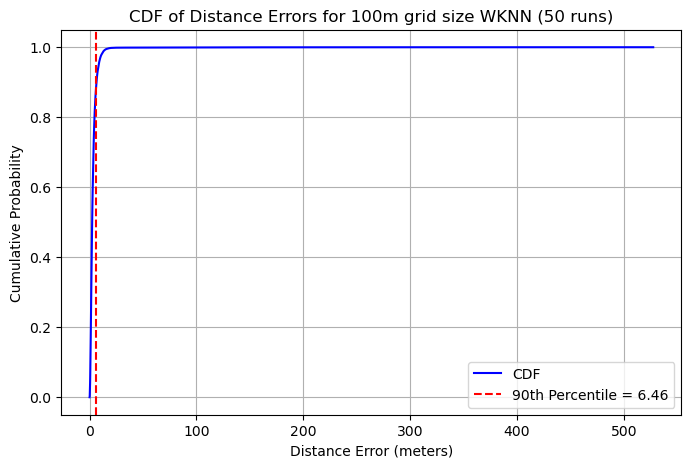

In [1]:
#!/usr/bin/env python
# coding: utf-8

# Import libraries
import json
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from typing import Dict, Tuple
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os
import time
from scipy.io import savemat
import dill as pickle
from sklearn import metrics
from scipy import stats

# GPU configuration
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # Select the GPU index

# Define all important parameters at the beginning
device = 'cuda' if torch.cuda.is_available() else 'cpu'
k_neighbors = 11
weights_type = 'distance'
input_grid_size = 100  # grid size based on filename
test_size = 0.2
num_runs = 50  # Number of runs for statistical confidence
random_seed = 42
folder_path = "Datasets/"
file_name = f"all_measurements_{input_grid_size}m_25k.json"
file_name_grid = f"all_measurements_grid_{input_grid_size}m.json"

# Create path directory for saving model weights and results
path_directory = f"finalmodels/WKNN/Grid_{input_grid_size}m/k_{k_neighbors}/weights_{weights_type}/"

# Create directory if it doesn't exist
if not os.path.exists(path_directory):
    os.makedirs(path_directory)

def load_json_file(folder_path: str, file_name: str) -> dict:
    file_path = Path(folder_path) / file_name
    try:
        with open(file_path, 'r') as file:
            return json.load(file)
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Error loading file: {e}")
        return None

def normalize_serving_cell_measurements(df):
    params = ['RSRP', 'RSRQ', 'RSSI', 'SINR']
    norm_params = {}
    
    for metric in params:
        col_name = f"Serving_{metric}"
        if col_name in df.columns:
            mean_val = df[col_name].mean()
            std_val = df[col_name].std()
            
            norm_params[f"{col_name}_mean"] = mean_val
            norm_params[f"{col_name}_std"] = std_val
            
            if std_val != 0:
                df[col_name] = (df[col_name] - mean_val) / std_val
            else:
                print(f"Warning: Standard deviation is 0 for {col_name}")
                df[col_name] = df[col_name] - mean_val
    
    return df, norm_params

def normalize_neighbor_cell_measurements(df, max_neighbors):
    params = ['RSRP', 'RSRQ', 'RSSI']
    norm_params = {}
    
    for i in range(1, max_neighbors + 1):
        for metric in params:
            col_name = f"Neighbor_{i}_{metric}"
            if col_name in df.columns:
                mean_val = df[col_name].mean()
                std_val = df[col_name].std()
                
                norm_params[f"{col_name}_mean"] = mean_val
                norm_params[f"{col_name}_std"] = std_val
                
                if std_val != 0:
                    df[col_name] = (df[col_name] - mean_val) / std_val
                else:
                    print(f"Warning: Standard deviation is 0 for {col_name}")
                    df[col_name] = df[col_name] - mean_val
    
    return df, norm_params

def normalize_position_minmax(df: pd.DataFrame) -> Tuple[pd.DataFrame, dict]:
    position_params = {
        'x_min': df['X_Position'].min(),
        'x_max': df['X_Position'].max(),
        'y_min': df['Y_Position'].min(),
        'y_max': df['Y_Position'].max()
    }
    
    df['X_Position'] = (df['X_Position'] - position_params['x_min']) / (position_params['x_max'] - position_params['x_min'])
    df['Y_Position'] = (df['Y_Position'] - position_params['y_min']) / (position_params['y_max'] - position_params['y_min'])
    
    return df, position_params

def preprocess_data(json_data):
    ue_data = []
    max_neighbors = 0
    for ue_index, ue in enumerate(json_data['UEs']):
        ue_info = {
            'UE_ID': ue['id'],
            'X_Position': ue['position']['x'],
            'Y_Position': ue['position']['y'],
            'Serving_PCI': ue['servingCell']['pci'],
            'Serving_RSRP': ue['servingCell']['rsrp'],
            'Serving_RSRQ': ue['servingCell']['rsrq'],
            'Serving_RSSI': ue['servingCell']['rssi'],
            'Serving_SINR': ue['servingCell']['sinr'],
            'Closest_Grid_dist': ue['gridDetail']['gridCenterDistance'],
            'Closest_Grid_X': ue['gridDetail']['gridCenterX'],
            'Closest_Grid_Y': ue['gridDetail']['gridCenterY'],
            'Closest_Grid_ID': ue['gridDetail']['gridId']
        }
        
        if 'neighborCells' in ue and isinstance(ue['neighborCells'], list):
            for i, neighbor in enumerate(ue['neighborCells']):
                ue_info[f'Neighbor_{i+1}_RSRP'] = neighbor.get('rsrp', 0)
                ue_info[f'Neighbor_{i+1}_RSRQ'] = neighbor.get('rsrq', 0)
                ue_info[f'Neighbor_{i+1}_RSSI'] = neighbor.get('rssi', 0)
            max_neighbors = max(max_neighbors, len(ue['neighborCells']))
        
        ue_data.append(ue_info)
    
    df = pd.DataFrame(ue_data)
    
    for i in range(1, max_neighbors + 1):
        for metric in ['RSRP', 'RSRQ', 'RSSI']:
            col_name = f'Neighbor_{i}_{metric}'
            if col_name not in df.columns:
                df[col_name] = 0
            else:
                df[col_name] = df[col_name].fillna(0)
    
    df, position_params = normalize_position_minmax(df)
    df.attrs.update(position_params)
    
    df, serving_params = normalize_serving_cell_measurements(df)
    df.attrs.update(serving_params)
    
    df, neighbor_params = normalize_neighbor_cell_measurements(df, max_neighbors)
    df.attrs.update(neighbor_params)
    
    # Extracting the feature set
    features = np.array(df.drop(['UE_ID', 'X_Position', 'Y_Position', 'Serving_PCI', 'Closest_Grid_dist', 
                                'Closest_Grid_X', 'Closest_Grid_Y', 'Closest_Grid_ID'], axis=1))
    
    # Extracting labels
    labels = np.array(df[['X_Position', 'Y_Position']])
    
    # Ground truth grid details for the UEs
    grid_id = np.array(df['Closest_Grid_ID'])
    
    # Shuffle the data before splitting
    indices = np.arange(len(features))
    np.random.shuffle(indices)
    features = features[indices]
    labels = labels[indices]
    grid_id = grid_id[indices]
    
    features = torch.tensor(features, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32)
    grid_id = torch.tensor(grid_id, dtype=torch.float32)
    
    return features, labels, grid_id, df

class WKNNPositioning:
    def __init__(self, k: int = 5, weights: str = 'distance'):
        self.k = k
        self.weights = weights
        self.X_train = None
        self.y_train = None
        self.grid_train = None
        self.position_params = None
    
    def fit(self, X_train, y_train, grid_train, position_params: dict):
        # Convert to numpy if tensors, ensuring they're on CPU first
        if torch.is_tensor(X_train):
            X_train = X_train.cpu() if X_train.is_cuda else X_train
            self.X_train = X_train.numpy()
        else:
            self.X_train = X_train
            
        if torch.is_tensor(y_train):
            y_train = y_train.cpu() if y_train.is_cuda else y_train
            self.y_train = y_train.numpy()
        else:
            self.y_train = y_train
            
        if torch.is_tensor(grid_train):
            grid_train = grid_train.cpu() if grid_train.is_cuda else grid_train
            self.grid_train = grid_train.numpy()
        else:
            self.grid_train = grid_train
            
        self.position_params = position_params
        return self
    
    def predict(self, X_test):
        start_time = time.time()
        # Convert input to numpy if tensor, ensuring it's on CPU first
        if torch.is_tensor(X_test):
            X_test = X_test.cpu() if X_test.is_cuda else X_test
            X_test = X_test.numpy()
        # Otherwise, use as is if already numpy
        predictions = []
        grid_predictions = []
        
        for test_point in X_test:
            # Compute distances using broadcasting
            diff = self.X_train - test_point[np.newaxis, :]
            distances = np.sqrt(np.sum(diff * diff, axis=1))
            
            # Get k nearest neighbors
            k_indices = np.argpartition(distances, self.k)[:self.k]
            k_distances = distances[k_indices]
            
            # Calculate weights
            if self.weights == 'distance':
                weights = 1 / (k_distances + 1e-10)
                weights = weights / np.sum(weights)
            else:
                weights = np.ones(self.k) / self.k
            
            # Weighted average for position prediction
            prediction = np.sum(self.y_train[k_indices] * weights[:, np.newaxis], axis=0)
            predictions.append(prediction)
            
            # Grid prediction using weighted voting
            grid_votes = self.grid_train[k_indices]
            unique_grids, vote_counts = np.unique(grid_votes, return_counts=True)
            grid_pred = unique_grids[np.argmax(vote_counts)]
            grid_predictions.append(grid_pred)
        
        predictions = np.array(predictions)
        
        # Denormalize predictions
        predictions[:, 0] = predictions[:, 0] * (self.position_params['x_max'] - self.position_params['x_min']) + self.position_params['x_min']
        predictions[:, 1] = predictions[:, 1] * (self.position_params['y_max'] - self.position_params['y_min']) + self.position_params['y_min']
        
        prediction_time = time.time() - start_time
        print(f"Prediction completed in {prediction_time:.2f} seconds")
        
        return predictions, np.array(grid_predictions), prediction_time

class GridDataPreprocessor:
    def __init__(self, json_path, json_file: str):
        """
        Initialize the preprocessor with path to JSON file
        """
        self.json_path = Path(json_path)/json_file
        self.raw_data = self._load_json()
        
    def _load_json(self) -> Dict:
        """Load JSON file and return the data"""
        with open(self.json_path, 'r') as f:
            return json.load(f)
    
    def _extract_grid_coordinates(self, grid_dict: Dict) -> torch.Tensor:
        """
        Extract coordinates from a single grid dictionary
        """
        points = []
        for point in grid_dict['gridDictionary']:
            points.append([
                point['gridCenterX'],
                point['gridCenterY'],
                point['gridId']
            ])
        return torch.tensor(points, dtype=torch.float32)
    
    def process_data(self) -> Dict[str, torch.Tensor]:
        """
        Process all grids in the data
        """
        all_grids = []
        
        for grid in self.raw_data['GRIDs']:
            grid_tensor = self._extract_grid_coordinates(grid)
            all_grids.append(grid_tensor)
            
        # Stack all grids into a single tensor
        all_grids_tensor = torch.stack(all_grids)
        
        # Split into coordinates and grid IDs
        grid_centers = all_grids_tensor[..., :2]  # Shape: (num_grids, num_points, 2)
        grid_ids = all_grids_tensor[..., 2]      # Shape: (num_grids, num_points)
        
        return {
            'coordinates': all_grids_tensor,      # Full data
            'grid_centers': grid_centers,         # Just x,y coordinates
            'grid_ids': grid_ids                  # Just grid IDs
        }
    
def gaussian_grid_probability(predicted_coords, grid_centers, sigma=50):
    # Calculate distances
    distances = np.sqrt(((grid_centers - predicted_coords[:, np.newaxis]) ** 2).sum(axis=2))
    # Apply Gaussian kernel
    probabilities = np.exp(-distances**2 / (2 * sigma**2))
    return probabilities / probabilities.sum(axis=1, keepdims=True)

def softmax_grid_probability(predicted_coords, grid_centers, temperature=1.0):
    # Calculate distances
    distances = np.sqrt(((grid_centers - predicted_coords[:, np.newaxis]) ** 2).sum(axis=2))
    # Apply softmax with temperature scaling
    logits = -distances / temperature
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    return exp_logits / exp_logits.sum(axis=1, keepdims=True)

def calculate_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    se = stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return mean, h

if __name__ == "__main__":
    print(f"Using device: {device}")
    print(f"Results will be saved to: {path_directory}")
    
    # Load and preprocess data
    json_data = load_json_file(folder_path, file_name)
    if json_data is None:
        print("Error loading data")
        exit()
    
    # Process grid information
    preprocessor_grid = GridDataPreprocessor(folder_path, file_name_grid)
    processed_data_grid = preprocessor_grid.process_data()
    
    coordinates = processed_data_grid['coordinates']    # Full data (x, y, grid_id)
    grid_centers = processed_data_grid['grid_centers'] # Just x,y coordinates
    grid_ids = processed_data_grid['grid_ids']
    center = grid_centers.numpy()[0]
    ids = grid_ids.numpy()[0]
    
    # Initial data preprocessing 
    features, labels, grid_ids_all, df = preprocess_data(json_data)
    
    # Get position normalization parameters for future use
    position_params = {
        'x_min': df.attrs['x_min'],
        'x_max': df.attrs['x_max'],
        'y_min': df.attrs['y_min'],
        'y_max': df.attrs['y_max']
    }
    
    # --- Single Run Evaluation ---
    print("\n--- Single Run Evaluation ---")
    
    # Split data with fixed random seed for reproducibility
    X_train, X_test, y_train, y_test, grid_train, grid_test = train_test_split(
        features, labels, grid_ids_all, test_size=test_size, random_state=random_seed
    )
    
    # Initialize WKNN model
    print(f"Training WKNN model with k={k_neighbors}, weights={weights_type}")
    start_time = time.time()
    
    # Initialize and train WKNN model
    wknn = WKNNPositioning(k=k_neighbors, weights=weights_type)
    wknn.fit(X_train, y_train, grid_train, position_params)
    
    training_time = time.time() - start_time
    print(f"Model trained in {training_time:.2f} seconds")
    
    # Make predictions
    predictions, grid_predictions, prediction_time = wknn.predict(X_test)
    
    # Calculate positioning error
    y_test_np = y_test.numpy() if torch.is_tensor(y_test) else y_test
    
    # Denormalize ground truth
    y_test_denorm = np.copy(y_test_np)
    y_test_denorm[:, 0] = y_test_np[:, 0] * (position_params['x_max'] - position_params['x_min']) + position_params['x_min']
    y_test_denorm[:, 1] = y_test_np[:, 1] * (position_params['y_max'] - position_params['y_min']) + position_params['y_min']
    
    # Calculate distance error
    distance_error = np.sqrt(np.sum((predictions - y_test_denorm) ** 2, axis=1))
    mean_error = np.mean(distance_error)
    percentile_90 = np.percentile(distance_error, 90)
    
    # Calculate distances for grid prediction methods
    distances = np.sqrt((center[:, np.newaxis, 0] - predictions[:, 0])**2 + (center[:, np.newaxis, 1] - predictions[:, 1])**2)

    # 1. Using reciprocal of distances
    reciprocals = 1 / distances
    column_sums = reciprocals.sum(axis=0)
    probabilities_rec = reciprocals / column_sums
    grid_predicted = np.argmax(probabilities_rec, axis=0)
    grid_real = grid_test.numpy() if torch.is_tensor(grid_test) else grid_test
    grid_accuracy = metrics.accuracy_score(grid_real, grid_predicted)
    
    # 2. Using Gaussian kernel
    probabilities_gauss = gaussian_grid_probability(predictions, center, sigma=50)
    grid_predicted_gauss = np.argmax(probabilities_gauss, axis=1)
    accuracy_gauss = metrics.accuracy_score(grid_real, grid_predicted_gauss)
    
    # 3. Using softmax
    probabilities_softmax = softmax_grid_probability(predictions, center, temperature=1.0)
    grid_predicted_softmax = np.argmax(probabilities_softmax, axis=1)
    accuracy_softmax = metrics.accuracy_score(grid_real, grid_predicted_softmax)
    
    # Print and save single run results
    print(f"\n--- Single Run Results ---")
    print(f"Grid Size: {input_grid_size}m")
    print(f"K value: {k_neighbors}")
    print(f"Weights type: {weights_type}")
    print(f"Mean 2D Error: {mean_error:.2f} meters")
    print(f"90th Percentile Error: {percentile_90:.2f} meters")
    print(f"Grid Accuracy (Reciprocal): {grid_accuracy:.4f}")
    print(f"Grid Accuracy (Gaussian): {accuracy_gauss:.4f}")
    print(f"Grid Accuracy (Softmax): {accuracy_softmax:.4f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Prediction Time: {prediction_time:.2f} seconds")
    
    # Save results to file
    with open(path_directory + 'results_single.txt', 'w') as f:
        f.write(f"Grid Size: {input_grid_size}m\n")
        f.write(f"K value: {k_neighbors}\n")
        f.write(f"Weights type: {weights_type}\n")
        f.write(f"Mean 2D Error: {mean_error:.2f} meters\n")
        f.write(f"90th Percentile Error: {percentile_90:.2f} meters\n")
        f.write(f"Grid Accuracy (Reciprocal): {grid_accuracy:.4f}\n")
        f.write(f"Grid Accuracy (Gaussian): {accuracy_gauss:.4f}\n")
        f.write(f"Grid Accuracy (Softmax): {accuracy_softmax:.4f}\n")
        f.write(f"Training Time: {training_time:.2f} seconds\n")
        f.write(f"Prediction Time: {prediction_time:.2f} seconds\n")
    
    # Plot CDF of positioning errors and save as PDF
    plt.figure(figsize=(8, 5))
    sorted_errors = np.sort(distance_error)
    cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
    plt.plot(sorted_errors, cdf, label="CDF", color="blue")
    plt.axvline(percentile_90, color="red", linestyle="--", 
                label=f"90th Percentile = {percentile_90:.2f}")
    plt.xlabel("Distance Error (meters)")
    plt.ylabel("Cumulative Probability")
    plt.title(f"CDF of Distance Errors for {input_grid_size}m grid size WKNN (Single Run)")
    plt.legend()
    plt.grid()
    plt.savefig(path_directory + 'error_cdf_single.pdf')
    
    # Save performance metrics for single run
    metrics_dict_single = {
        'mean_error': mean_error,
        'percentile_90': percentile_90,
        'grid_accuracy': grid_accuracy,
        'accuracy_gauss': accuracy_gauss,
        'accuracy_softmax': accuracy_softmax,
        'training_time': training_time,
        'prediction_time': prediction_time,
        'sorted_errors': sorted_errors,
        'cdf': cdf
    }
    
    savemat(path_directory + 'metrics_single.mat', metrics_dict_single)
    with open(path_directory + 'metrics_single.pkl', 'wb') as file:
        pickle.dump(metrics_dict_single, file)
    
    # --- Multiple runs for statistical confidence ---
    print(f"\n--- Starting Multiple Run Analysis ({num_runs} runs) ---")
    
    # Lists to store metrics from all runs
    dist_prob_list = []  # Reciprocal distance accuracy
    gauss_prob_list = []  # Gaussian kernel accuracy
    softm_prob_list = []  # Softmax accuracy
    percentile_90_list = []  # 90th percentile errors
    mean_err_list = []  # Mean errors
    prediction_time_list = []  # Prediction times
    all_distance_errors = []  # All distance errors across all runs
    
    # Create and fit the base model once to reuse in each run
    base_wknn = WKNNPositioning(k=k_neighbors, weights=weights_type)
    
    # Start multiple runs
    for run in range(num_runs):
        if run % 10 == 0:
            print(f"Run {run+1}/{num_runs}...")
        
        # Preprocess data with different random shuffling
        features_run, labels_run, grid_ids_run, _ = preprocess_data(json_data)
        
        # Train/test split for this run
        train_size = int((1-test_size) * len(features_run))
        X_train_run = features_run[:train_size]
        y_train_run = labels_run[:train_size]
        grid_train_run = grid_ids_run[:train_size]
        X_test_run = features_run[train_size:]
        y_test_run = labels_run[train_size:]
        grid_test_run = grid_ids_run[train_size:]
        
        # Fit and predict using WKNN
        run_start_time = time.time()
        wknn_run = WKNNPositioning(k=k_neighbors, weights=weights_type)
        wknn_run.fit(X_train_run, y_train_run, grid_train_run, position_params)
        predictions_run, grid_predictions_run, prediction_time_run = wknn_run.predict(X_test_run)
        
        # Denormalize ground truth
        y_test_np_run = y_test_run.numpy() if torch.is_tensor(y_test_run) else y_test_run
        y_test_denorm_run = np.copy(y_test_np_run)
        y_test_denorm_run[:, 0] = y_test_np_run[:, 0] * (position_params['x_max'] - position_params['x_min']) + position_params['x_min']
        y_test_denorm_run[:, 1] = y_test_np_run[:, 1] * (position_params['y_max'] - position_params['y_min']) + position_params['y_min']
        
        # Calculate distance error
        distance_error_run = np.sqrt(np.sum((predictions_run - y_test_denorm_run) ** 2, axis=1))
        mean_error_run = np.mean(distance_error_run)
        percentile_90_run = np.percentile(distance_error_run, 90)
        
        # Calculate distances for grid prediction
        distances_run = np.sqrt((center[:, np.newaxis, 0] - predictions_run[:, 0])**2 + 
                           (center[:, np.newaxis, 1] - predictions_run[:, 1])**2)
        
        # Calculate reciprocal distance accuracy
        reciprocals_run = 1 / distances_run
        column_sums_run = reciprocals_run.sum(axis=0)
        probabilities_rec_run = reciprocals_run / column_sums_run
        grid_predicted_run = np.argmax(probabilities_rec_run, axis=0)
        grid_real_run = grid_test_run.numpy() if torch.is_tensor(grid_test_run) else grid_test_run
        accuracy_run = metrics.accuracy_score(grid_real_run, grid_predicted_run)
        
        # Calculate Gaussian kernel accuracy
        probabilities_gauss_run = gaussian_grid_probability(predictions_run, center, sigma=50)
        grid_predicted_gauss_run = np.argmax(probabilities_gauss_run, axis=1)
        accuracy_gauss_run = metrics.accuracy_score(grid_real_run, grid_predicted_gauss_run)
        
        # Calculate softmax accuracy
        probabilities_softmax_run = softmax_grid_probability(predictions_run, center, temperature=1.0)
        grid_predicted_softmax_run = np.argmax(probabilities_softmax_run, axis=1)
        accuracy_softmax_run = metrics.accuracy_score(grid_real_run, grid_predicted_softmax_run)
        
        # Store metrics for this run
        dist_prob_list.append(accuracy_run)
        gauss_prob_list.append(accuracy_gauss_run)
        softm_prob_list.append(accuracy_softmax_run)
        percentile_90_list.append(percentile_90_run)
        mean_err_list.append(mean_error_run)
        prediction_time_list.append(prediction_time_run)
        
        # Store all distance errors for comprehensive CDF
        all_distance_errors.extend(distance_error_run.tolist())
    
    # Calculate mean and confidence intervals for all metrics
    mean_accuracy, margin_of_error_accuracy = calculate_confidence_interval(dist_prob_list)
    mean_accuracy_gauss, margin_of_error_accuracy_gauss = calculate_confidence_interval(gauss_prob_list)
    mean_accuracy_softmax, margin_of_error_accuracy_softmax = calculate_confidence_interval(softm_prob_list)
    mean_percentile_90, margin_of_error_percentile_90 = calculate_confidence_interval(percentile_90_list)
    mean_2D_err, margin_of_error_2D_err = calculate_confidence_interval(mean_err_list)
    mean_prediction_time, margin_of_error_prediction_time = calculate_confidence_interval(prediction_time_list)

    # Print results of multiple runs with confidence intervals
    print("\n--- Multiple Run Results with 95% Confidence Intervals ---")
    print(f"Mean 2D Error: {mean_2D_err:.2f} ± {margin_of_error_2D_err:.2f} meters")
    print(f"90th Percentile Error: {mean_percentile_90:.2f} ± {margin_of_error_percentile_90:.2f} meters")
    print(f"Grid Accuracy (Reciprocal): {mean_accuracy:.4f} ± {margin_of_error_accuracy:.4f}")
    print(f"Grid Accuracy (Gaussian): {mean_accuracy_gauss:.4f} ± {margin_of_error_accuracy_gauss:.4f}")
    print(f"Grid Accuracy (Softmax): {mean_accuracy_softmax:.4f} ± {margin_of_error_accuracy_softmax:.4f}")
    print(f"Mean Prediction Time: {mean_prediction_time:.4f} ± {margin_of_error_prediction_time:.4f} seconds")
    
    # Save results to file
    with open(path_directory + 'results_multiple.txt', 'w') as f:
        f.write(f"Grid Size: {input_grid_size}m\n")
        f.write(f"K value: {k_neighbors}\n")
        f.write(f"Weights type: {weights_type}\n")
        f.write(f"Number of runs: {num_runs}\n\n")
        f.write(f"Mean 2D Error: {mean_2D_err:.2f} ± {margin_of_error_2D_err:.2f} meters\n")
        f.write(f"90th Percentile Error: {mean_percentile_90:.2f} ± {margin_of_error_percentile_90:.2f} meters\n")
        f.write(f"Grid Accuracy (Reciprocal): {mean_accuracy:.4f} ± {margin_of_error_accuracy:.4f}\n")
        f.write(f"Grid Accuracy (Gaussian): {mean_accuracy_gauss:.4f} ± {margin_of_error_accuracy_gauss:.4f}\n")
        f.write(f"Grid Accuracy (Softmax): {mean_accuracy_softmax:.4f} ± {margin_of_error_accuracy_softmax:.4f}\n")
        f.write(f"Mean Prediction Time: {mean_prediction_time:.4f} ± {margin_of_error_prediction_time:.4f} seconds\n")
    
    # Plot comprehensive CDF from all runs
    plt.figure(figsize=(8, 5))
    all_sorted_errors = np.sort(all_distance_errors)
    all_cdf = np.arange(1, len(all_sorted_errors) + 1) / len(all_sorted_errors)
    
    # Calculate the 90th percentile from the combined errors
    all_percentile_90 = np.percentile(all_distance_errors, 90)
    
    plt.plot(all_sorted_errors, all_cdf, label="CDF", color="blue")
    plt.axvline(all_percentile_90, color="red", linestyle="--", 
                label=f"90th Percentile = {all_percentile_90:.2f}")
    plt.xlabel("Distance Error (meters)")
    plt.ylabel("Cumulative Probability")
    plt.title(f"CDF of Distance Errors for {input_grid_size}m grid size WKNN ({num_runs} runs)")
    plt.legend()
    plt.grid()
    plt.savefig(path_directory + 'error_cdf_multiple.pdf')
    
    # Save comprehensive metrics with confidence intervals
    metrics_dict_multiple = {
        'mean_error': mean_2D_err,
        'mean_error_margin': margin_of_error_2D_err,
        'percentile_90': mean_percentile_90,
        'percentile_90_margin': margin_of_error_percentile_90,
        'accuracy': mean_accuracy,
        'accuracy_margin': margin_of_error_accuracy,
        'accuracy_gauss': mean_accuracy_gauss,
        'accuracy_gauss_margin': margin_of_error_accuracy_gauss,
        'accuracy_softmax': mean_accuracy_softmax,
        'accuracy_softmax_margin': margin_of_error_accuracy_softmax,
        'prediction_time': mean_prediction_time,
        'prediction_time_margin': margin_of_error_prediction_time,
        'num_runs': num_runs,
        'all_sorted_errors': all_sorted_errors,
        'all_cdf': all_cdf,
        'all_percentile_90': all_percentile_90,
        'mean_errors_per_run': np.array(mean_err_list),
        'percentile_90_per_run': np.array(percentile_90_list),
        'accuracy_per_run': np.array(dist_prob_list),
        'accuracy_gauss_per_run': np.array(gauss_prob_list),
        'accuracy_softmax_per_run': np.array(softm_prob_list),
        'prediction_time_per_run': np.array(prediction_time_list)
    }
    
    savemat(path_directory + 'metrics_multiple.mat', metrics_dict_multiple)
    with open(path_directory + 'metrics_multiple.pkl', 'wb') as file:
        pickle.dump(metrics_dict_multiple, file)
    
    # Save model using pickle
    with open(path_directory + 'wknn_model.pkl', 'wb') as file:
        pickle.dump(wknn, file)
    
    print(f"\nAll results saved to {path_directory}")
    print(f"Total evaluation time for {num_runs} runs: {time.time() - start_time:.2f} seconds")